In [1]:
from eoxhub import check_compatibility
check_compatibility("user-2022.10-14", dependencies=[])

# Crop-classification using Sentinel-2 time-series

This notebook implements a crop classification algorithm for Sentinel-2 time-series based on deep learning. The input time-series are derived from the signals computed by the Eurocrops BYOA. The method here implemented is described in more detail in the [crop-classification marker blog-post](https://medium.com/sentinel-hub/area-monitoring-crop-type-marker-1e70f672bf44).

For more examples on how to create markers for monitoring agricultural activity using Sentinel-2 signals, consult [this blog series](https://medium.com/sentinel-hub/area-monitoring-concept-effc2c262583).

This notebook will use a sample of pre-downloaded signals, and can be run on a CPU-based instance or laptop.

**Table of Contents**:

 0. [Constants](#constants)
 1. [Retrieve signals and labels](#retrieve-signals)
 2. [AI-ready dataset](#dataset)
 3. [Model training](#model-training)
 4. [Model evaluation](#model-evaluation)

In [2]:
import os
import sys

!{sys.executable} -m pip install torch torchvision
os.environ['EDC_PATH'] + "/notebooks/contributions/eurocrops-model"
sys.path.append(os.path.join(os.environ['EDC_PATH'] + "/notebooks/contributions/eurocrops-model"))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/776.4 MB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/776.4 MB 60.1 MB/s eta 0:00:13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/776.4 MB 79.9 MB/s eta 0:00:10

     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/776.4 MB 154.0 MB/s eta 0:00:05

     ━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.7/776.4 MB 138.4 MB/s eta 0:00:06

     ━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/776.4 MB 225.6 MB/s eta 0:00:04

     ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/776.4 MB 178.2 MB/s eta 0:00:05

     ━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/776.4 MB 214.8 MB/s eta 0:00:04

     ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/776.4 MB 204.7 MB/s eta 0:00:04

     ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/776.4 MB 179.5 MB/s eta 0:00:04

     ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/776.4 MB 157.0 MB/s eta 0:00:05

     ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/776.4 MB 153.5 MB/s eta 0:00:05

     ━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/776.4 MB 152.4 MB/s eta 0:00:05

     ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/776.4 MB 171.1 MB/s eta 0:00:04

     ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/776.4 MB 171.6 MB/s eta 0:00:04

     ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/776.4 MB 140.2 MB/s eta 0:00:05

     ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/776.4 MB 153.7 MB/s eta 0:00:05

     ━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.2/776.4 MB 158.7 MB/s eta 0:00:05

     ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.9/776.4 MB 187.4 MB/s eta 0:00:04

     ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/776.4 MB 141.7 MB/s eta 0:00:05

     ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/776.4 MB 175.2 MB/s eta 0:00:04

     ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/776.4 MB 182.0 MB/s eta 0:00:04

     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.4/776.4 MB 178.4 MB/s eta 0:00:04

     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/776.4 MB 192.2 MB/s eta 0:00:04

     ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.7/776.4 MB 210.0 MB/s eta 0:00:03

     ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.9/776.4 MB 202.8 MB/s eta 0:00:03

     ━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/776.4 MB 166.8 MB/s eta 0:00:04

     ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/776.4 MB 157.8 MB/s eta 0:00:04

     ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/776.4 MB 165.7 MB/s eta 0:00:04

     ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━ 237.4/776.4 MB 170.2 MB/s eta 0:00:04

     ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/776.4 MB 52.1 MB/s eta 0:00:11

     ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/776.4 MB 155.4 MB/s eta 0:00:04

     ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/776.4 MB 127.2 MB/s eta 0:00:05

     ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/776.4 MB 192.4 MB/s eta 0:00:03

     ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━ 280.8/776.4 MB 209.7 MB/s eta 0:00:03

     ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 286.8/776.4 MB 189.9 MB/s eta 0:00:03

     ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 291.5/776.4 MB 152.9 MB/s eta 0:00:04

     ━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━ 302.9/776.4 MB 159.6 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━ 308.0/776.4 MB 148.6 MB/s eta 0:00:04

     ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 317.9/776.4 MB 140.0 MB/s eta 0:00:04

     ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 323.0/776.4 MB 136.4 MB/s eta 0:00:04

     ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 334.4/776.4 MB 161.2 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━ 339.5/776.4 MB 151.5 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 350.7/776.4 MB 161.2 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 356.6/776.4 MB 175.7 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 362.8/776.4 MB 185.1 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━ 374.5/776.4 MB 165.9 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 379.6/776.4 MB 161.8 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━ 386.0/776.4 MB 153.9 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━ 393.6/776.4 MB 195.0 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━ 408.0/776.4 MB 199.2 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━ 414.0/776.4 MB 176.4 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━ 427.8/776.4 MB 197.8 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 433.1/776.4 MB 172.5 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 440.2/776.4 MB 116.8 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 446.4/776.4 MB 117.2 MB/s eta 0:00:03

     ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━ 453.6/776.4 MB 174.2 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 466.2/776.4 MB 173.9 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━ 471.9/776.4 MB 163.1 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━ 477.8/776.4 MB 170.7 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━ 491.1/776.4 MB 194.1 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━ 497.4/776.4 MB 185.6 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━ 509.7/776.4 MB 169.3 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━ 515.1/776.4 MB 161.9 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 528.8/776.4 MB 202.0 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 533.4/776.4 MB 168.3 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━ 539.4/776.4 MB 148.5 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 549.9/776.4 MB 150.2 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━ 556.2/776.4 MB 172.6 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━ 567.4/776.4 MB 162.3 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━ 574.7/776.4 MB 198.0 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━ 587.6/776.4 MB 178.9 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━ 592.5/776.4 MB 166.3 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━ 605.3/776.4 MB 194.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 608.6/776.4 MB 147.7 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━ 615.4/776.4 MB 141.9 MB/s eta 0:00:02

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 627.6/776.4 MB 166.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━ 632.0/776.4 MB 157.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━ 642.8/776.4 MB 152.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━ 649.1/776.4 MB 173.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━ 660.4/776.4 MB 159.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━ 666.4/776.4 MB 160.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 672.5/776.4 MB 174.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 684.3/776.4 MB 170.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━ 690.1/776.4 MB 189.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━ 702.0/776.4 MB 165.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━ 707.9/776.4 MB 165.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━ 713.9/776.4 MB 169.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 724.2/776.4 MB 146.0 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━ 730.2/776.4 MB 149.1 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━ 736.0/776.4 MB 167.2 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 748.9/776.4 MB 189.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━ 753.7/776.4 MB 168.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 765.2/776.4 MB 169.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 770.4/776.4 MB 162.7 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 776.3/776.4 MB 170.3 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.4/776.4 MB 547.3 kB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/19.1 MB ? eta -:--:--

     ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/19.1 MB 167.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 200.9 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 193.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 193.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 193.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 193.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 193.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 193.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 193.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19.1/19.1 MB 193.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 19.8 MB/s eta 0:00:00


In [3]:
import json
import logging
import sys
import zipfile

import geopandas as gpd
import numpy as np
import pandas as pd
import subprocess
from lstm import LSTM
from polygon import PolyDataset
from transforms import get_sample_n_timestamps
from utils import test, train
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader

from sentinelhub import parse_time

## 0. Constants <a name=constants></a>

This section initialises paths, constants and utility functions used in the notebook.

In [4]:
# path to local folders, change as desired
INPUT_FOLDER = "./input"
RESULTS_FOLDER = "./output"

# name of files and folders of downloaded signals, do not change
DATAFILE = "ml-example-data.zip"
DOWNLOAD_URL = f"https://sinergise0-my.sharepoint.com/:u:/g/personal/nejc_vesel_sinergise_com/ETMx7NG-JHpBntNMJfnsCOMBVuEegDjYq8WtTmJYl8tZ-A?e=Ck5opE&download=1"
EUROCROPS_GPKG = "input_geometries.gpkg"
SIGNALS_FOLDER = "ml-example-signals"


# utility function to read json payload into a dataframe
def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)


# utility function to log training progress
def define_logger(logger_name) -> logging.Logger:
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter("[%(asctime)s] {%(filename)s:%(lineno)d} %(levelname)s - %(message)s")

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(formatter)
    logger.addHandler(stdout_handler)
    return logger

## 1. Retrieve signals and labels <a name=retrieve-signals></a>

In this Section, signals are read from JSON files, while the labels used during model training are extracted from the Eurocrops dataset. For this notebook, sample files are provided and downloaded locally in the following cells. 

In [5]:
if not os.path.exists(INPUT_FOLDER):
    os.mkdir(INPUT_FOLDER)

In [6]:
wget_str = f"wget {DOWNLOAD_URL} -O {os.path.join(INPUT_FOLDER, DATAFILE)}"
subprocess.call(wget_str.split(" "))

--2022-10-25 05:03:40--  https://sinergise0-my.sharepoint.com/:u:/g/personal/nejc_vesel_sinergise_com/ETMx7NG-JHpBntNMJfnsCOMBVuEegDjYq8WtTmJYl8tZ-A?e=Ck5opE&download=1
Resolving sinergise0-my.sharepoint.com (sinergise0-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to sinergise0-my.sharepoint.com (sinergise0-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 

302 Found
Location: /personal/nejc_vesel_sinergise_com/Documents/ml-example-data.zip?ga=1 [following]
--2022-10-25 05:03:41--  https://sinergise0-my.sharepoint.com/personal/nejc_vesel_sinergise_com/Documents/ml-example-data.zip?ga=1
Reusing existing connection to sinergise0-my.sharepoint.com:443.
HTTP request sent, awaiting response... 

200 OK
Length: 88085785 (84M) [application/x-zip-compressed]
Saving to: ‘./input/ml-example-data.zip’

     0K .......... .......... .......... .......... ..........  0% 5.70M 15s
    50K .......... .......... .......... .......... ..........  0% 5.16M 15s
   100K .......... .......... .......... .......... ..........  0% 3.81M 18s
   150K .......... .......... .......... .......... ..........  0% 5.42M 17s
   200K .......... .......... .......... .......... ..........  0%  229M 14s
   250K .......... .......... .......... .......... ..........  0% 5.37M 14s
   300K .......... .......... .......... .......... ..........  0%  109M 12s
   350K .......... .......... .......... .......... ..........  0% 5.85M 12s
   400K .......... .......... .......... .......... ..........  0% 80.2M 11s
   450K .......... .......... .......... .......... ..........  0% 75.7M 10s
   500K .......... .......... .......... .......... ..........  0% 77.3M 9s
   550K .......... .......... .......... ..........

........ ..........  5% 7.19M 4s
  4400K .......... .......... .......... .......... ..........  5%  293M 4s
  4450K .......... .......... .......... .......... ..........  5%  307M 4s
  4500K .......... .......... .......... .......... ..........  5%  345M 4s
  4550K .......... .......... .......... .......... ..........  5%  355M 4s
  4600K .......... .......... .......... .......... ..........  5%  188M 3s
  4650K .......... .......... .......... .......... ..........  5%  138M 3s
  4700K .......... .......... .......... .......... ..........  5%  340M 3s
  4750K .......... .......... .......... .......... ..........  5%  341M 3s
  4800K .......... .......... .......... .......... ..........  5% 70.0M 3s
  4850K .......... .......... .......... .......... ..........  5%  302M 3s
  4900K .......... .......... .......... .......... ..........  5%  342M 3s
  4950K .......... .......... .......... .......... ..........  5%  190M 3s
  5000K .......... .......... .......... .......... ...

..... .......... .......... 28%  450K 1s
 24100K .......... .......... .......... .......... .......... 28%  292M 1s
 24150K .......... .......... .......... .......... .......... 28%  164M 1s
 24200K .......... .......... .......... .......... .......... 28% 86.7M 1s
 24250K .......... .......... .......... .......... .......... 28% 85.0M 1s
 24300K .......... .......... .......... .......... .......... 28%  143M 1s
 24350K .......... .......... .......... .......... .......... 28% 32.5M 1s
 24400K .......... .......... .......... .......... .......... 28%  103M 1s
 24450K .......... .......... .......... .......... .......... 28%  154M 1s
 24500K .......... .......... .......... .......... .......... 28%  106M 1s
 24550K .......... .......... .......... .......... .......... 28% 77.4M 1s
 24600K .......... .......... .......... .......... .......... 28%  241M 1s
 24650K .......... .......... .......... .......... .......... 28%  113M 1s
 24700K .......... .......... .......... ......

... .......... .......... .......... 56%  413K 1s
 48300K .......... .......... .......... .......... .......... 56%  274M 1s
 48350K .......... .......... .......... .......... .......... 56%  111M 1s
 48400K .......... .......... .......... .......... .......... 56%  117M 1s
 48450K .......... .......... .......... .......... .......... 56%  176M 1s
 48500K .......... .......... .......... .......... .......... 56% 71.6M 1s
 48550K .......... .......... .......... .......... .......... 56%  100M 1s
 48600K .......... .......... .......... .......... .......... 56%  104M 1s
 48650K .......... .......... .......... .......... .......... 56% 33.0M 1s
 48700K .......... .......... .......... .......... .......... 56%  144M 1s
 48750K .......... .......... .......... .......... .......... 56%  204M 1s
 48800K .......... .......... .......... .......... .......... 56% 27.5M 1s
 48850K .......... .......... .......... .......... .......... 56% 65.7M 1s
 48900K .......... .......... ........

..... .......... .......... .......... .......... 85% 19.5K 1s
 73400K .......... .......... .......... .......... .......... 85%  208M 1s
 73450K .......... .......... .......... .......... .......... 85%  161M 1s
 73500K .......... .......... .......... .......... .......... 85%  255M 1s
 73550K .......... .......... .......... .......... .......... 85%  322M 1s
 73600K .......... .......... .......... .......... .......... 85%  227M 1s
 73650K .......... .......... .......... .......... .......... 85%  238M 1s
 73700K .......... .......... .......... .......... .......... 85%  307M 1s
 73750K .......... .......... .......... .......... .......... 85%  268M 1s
 73800K .......... .......... .......... .......... .......... 85%  230M 1s
 73850K .......... .......... .......... .......... .......... 85%  253M 1s
 73900K .......... .......... .......... .......... .......... 85%  326M 1s
 73950K .......... .......... .......... .......... .......... 86%  285M 1s
 74000K .......... ......

0

In [7]:
# unzip files
with zipfile.ZipFile(os.path.join(INPUT_FOLDER, DATAFILE), "r") as zip_ref:
    zip_ref.extractall(INPUT_FOLDER)

In [8]:
!ls {INPUT_FOLDER}

input_geometries.gpkg  ml-example-data.zip  ml-example-signals


Read signals from JSON files as returned by Statistical API and create a dataframe.

In [9]:
dfs = []
for result_json in os.listdir(os.path.join(INPUT_FOLDER, "ml-example-signals")):
    with open(os.path.join(INPUT_FOLDER, "ml-example-signals", result_json)) as f:
        result = json.load(f)

    result_df = stats_to_df(result["response"])
    result_df["identifier"] = int(result["identifier"])
    dfs.append(result_df)

signals = pd.concat(dfs)

Check size of dataset and one time observation.

In [10]:
len(signals)

157500

In [11]:
signals.iloc[0]

interval_from            2021-01-05
interval_to              2021-01-06
clm_B0_min                      1.0
clm_B0_max                      1.0
clm_B0_mean                     1.0
                            ...    
bands_B12_mean             0.028348
bands_B12_stDev            0.003333
bands_B12_sampleCount            96
bands_B12_noDataCount            65
identifier                   331393
Name: 0, Length: 93, dtype: object

Read labels from provided geopackage file. These labels can be directly retrieved from GeoDB.

In [12]:
eurocrops_gdf = gpd.read_file(os.path.join(INPUT_FOLDER, EUROCROPS_GPKG))

Merge signals and crop labels into a single dataframe, by looking at the identifier of the field of interest (FOI).

In [13]:
eurocrops_signals = pd.merge(eurocrops_gdf, signals, on="identifier")

In [14]:
eurocrops_signals.iloc[0]

identifier                                         296351
created_at               2022-07-06T21:34:12.027081+00:00
modified_at                                          None
_fid                                                  NaN
fs_kennung                                            NaN
                                       ...               
bands_B12_max                                      0.3369
bands_B12_mean                                    0.28427
bands_B12_stDev                                   0.03697
bands_B12_sampleCount                                 112
bands_B12_noDataCount                                  72
Name: 0, Length: 121, dtype: object

## 2. AI-ready dataset <a name=dataset></a>

This Section adds some features to be added to the raw bands which will be used by the model.

In [15]:
# add column for cloud probability
eurocrops_signals["CLP"] = eurocrops_signals["clp_B0_mean"] / 255
# compute NDVI
eurocrops_signals["NDVI"] = (eurocrops_signals["bands_B7_mean"] - eurocrops_signals["bands_B3_mean"]) / (
    eurocrops_signals["bands_B7_mean"] + eurocrops_signals["bands_B3_mean"]
)
# compute day-of-year from timestamp
eurocrops_signals["DOY"] = eurocrops_signals.interval_from.apply(lambda x: x.timetuple().tm_yday)

In [16]:
# get name of columns to be used as features, i.e. mean values of raw bands
feature_cols = [x for x in eurocrops_signals.columns if x.startswith("bands_") and x.endswith("_mean")]
# name of utility features
doy_feature = "DOY"
crop_type_feature = "ec_hcat_c"
crop_name_feature = "ec_hcat_n"
label_feature = "label"
identifier_feature = "identifier"

Map all the possible crop-types to specific groups assigned in Eurocrops.

In [17]:
crop_id_to_label_mapping = {val: idx for idx, val in enumerate(eurocrops_signals[crop_type_feature].unique())}

In [18]:
crop_id_to_name_mapping = {
    crop_id: crop_name
    for crop_id, crop_name in eurocrops_signals[[crop_type_feature, crop_name_feature]].drop_duplicates().values
}

In [19]:
eurocrops_signals[label_feature] = eurocrops_signals[crop_type_feature].map(crop_id_to_label_mapping)

Split the signals into a training and validation set. This datasets are demonstrative only, as in reality, a larger dataset would be required, and more robust validation strategies required to robustly estimate the performance of the model.

In [20]:
train_ids, val_ids = train_test_split(
    eurocrops_signals[identifier_feature].unique(), train_size=0.6, test_size=0.4, random_state=42
)

In [21]:
train_df = eurocrops_signals[eurocrops_signals[identifier_feature].isin(train_ids)]
val_df = eurocrops_signals[eurocrops_signals[identifier_feature].isin(val_ids)]

Create the training and validation datasets to be used for model training and validation.

In [22]:
train_poly_dataset = PolyDataset(
    train_df,
    feature_cols=feature_cols,
    label_col=label_feature,
    poly_id_col=identifier_feature,
    doys_col=doy_feature,
    online_transform=get_sample_n_timestamps(40),
)

val_poly_dataset = PolyDataset(
    val_df,
    feature_cols=feature_cols,
    label_col=label_feature,
    poly_id_col=identifier_feature,
    doys_col=doy_feature,
    online_transform=get_sample_n_timestamps(40),
)

## 3. Model training <a name=model-training></a>

In this Section, a LSTM model is trained on the signals for estimation of crop-type. The parameters of the LSTM might need tuning to different use-cases.

In [23]:
BATCH_SIZE = 16
N_WORKERS = 4
SHUFFLE = True

The number of epochs is set to 5 to for this demonstration. For more accurate results, it is recommended that this is increased (i.e. to 20 or 30). 

In [24]:
N_EPOCHS = 5 

In [25]:
train_loader = DataLoader(dataset=train_poly_dataset, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=SHUFFLE)

val_loader = DataLoader(dataset=val_poly_dataset, batch_size=BATCH_SIZE, num_workers=N_WORKERS, shuffle=False)

Initialise the model.

In [26]:
lstm = LSTM(
    input_dim=len(feature_cols),
    n_classes=eurocrops_signals[label_feature].nunique(),
    hidden_dims=128,
    num_rnn_layers=3,
    dropout=0.2,
    bidirectional=True,
    use_batchnorm=False,
    use_layernorm=True,
)

Initialise the optimiser.

In [27]:
optimizer = Adam(
    filter(lambda x: x.requires_grad, lstm.parameters()),
    betas=(0.9, 0.98),
    eps=1e-09,
    lr=0.001,
)

Initialise the logger.

In [28]:
logger = define_logger("Training")

Train the model !!

In [29]:
lstm = train(lstm, optimizer, train_loader, val_loader, N_EPOCHS, verbose=False, logger=logger)

[2022-10-25 05:05:56,135] {utils.py:87} INFO - Epoch 0: train loss 2.269 | val loss 1.974 | val acc = 0.434


[2022-10-25 05:07:04,745] {utils.py:87} INFO - Epoch 1: train loss 1.864 | val loss 1.842 | val acc = 0.498


[2022-10-25 05:08:15,846] {utils.py:87} INFO - Epoch 2: train loss 1.687 | val loss 1.696 | val acc = 0.557


[2022-10-25 05:09:26,054] {utils.py:87} INFO - Epoch 3: train loss 1.555 | val loss 1.566 | val acc = 0.569


[2022-10-25 05:10:35,850] {utils.py:87} INFO - Epoch 4: train loss 1.549 | val loss 1.529 | val acc = 0.575


## 4. Model evaluation <a name=model-evaluation></a>

This Section evaluates the performance of the trained model on the validation dataset. Perfomance is displayed as a confusion matrix, where estimated and reference crop-types are compared.

In [30]:
import numpy as np

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = np.nanmax(cm) / 1.5 if normalize else np.nanmax(cm) / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()


In [32]:
predictions, targets, polygon_ids, logprobabilities = test(lstm, val_loader)

In [33]:
cm = confusion_matrix(targets, predictions, labels=list(crop_id_to_label_mapping.values()))

/tmp/ipykernel_70/2388789195.py:57: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


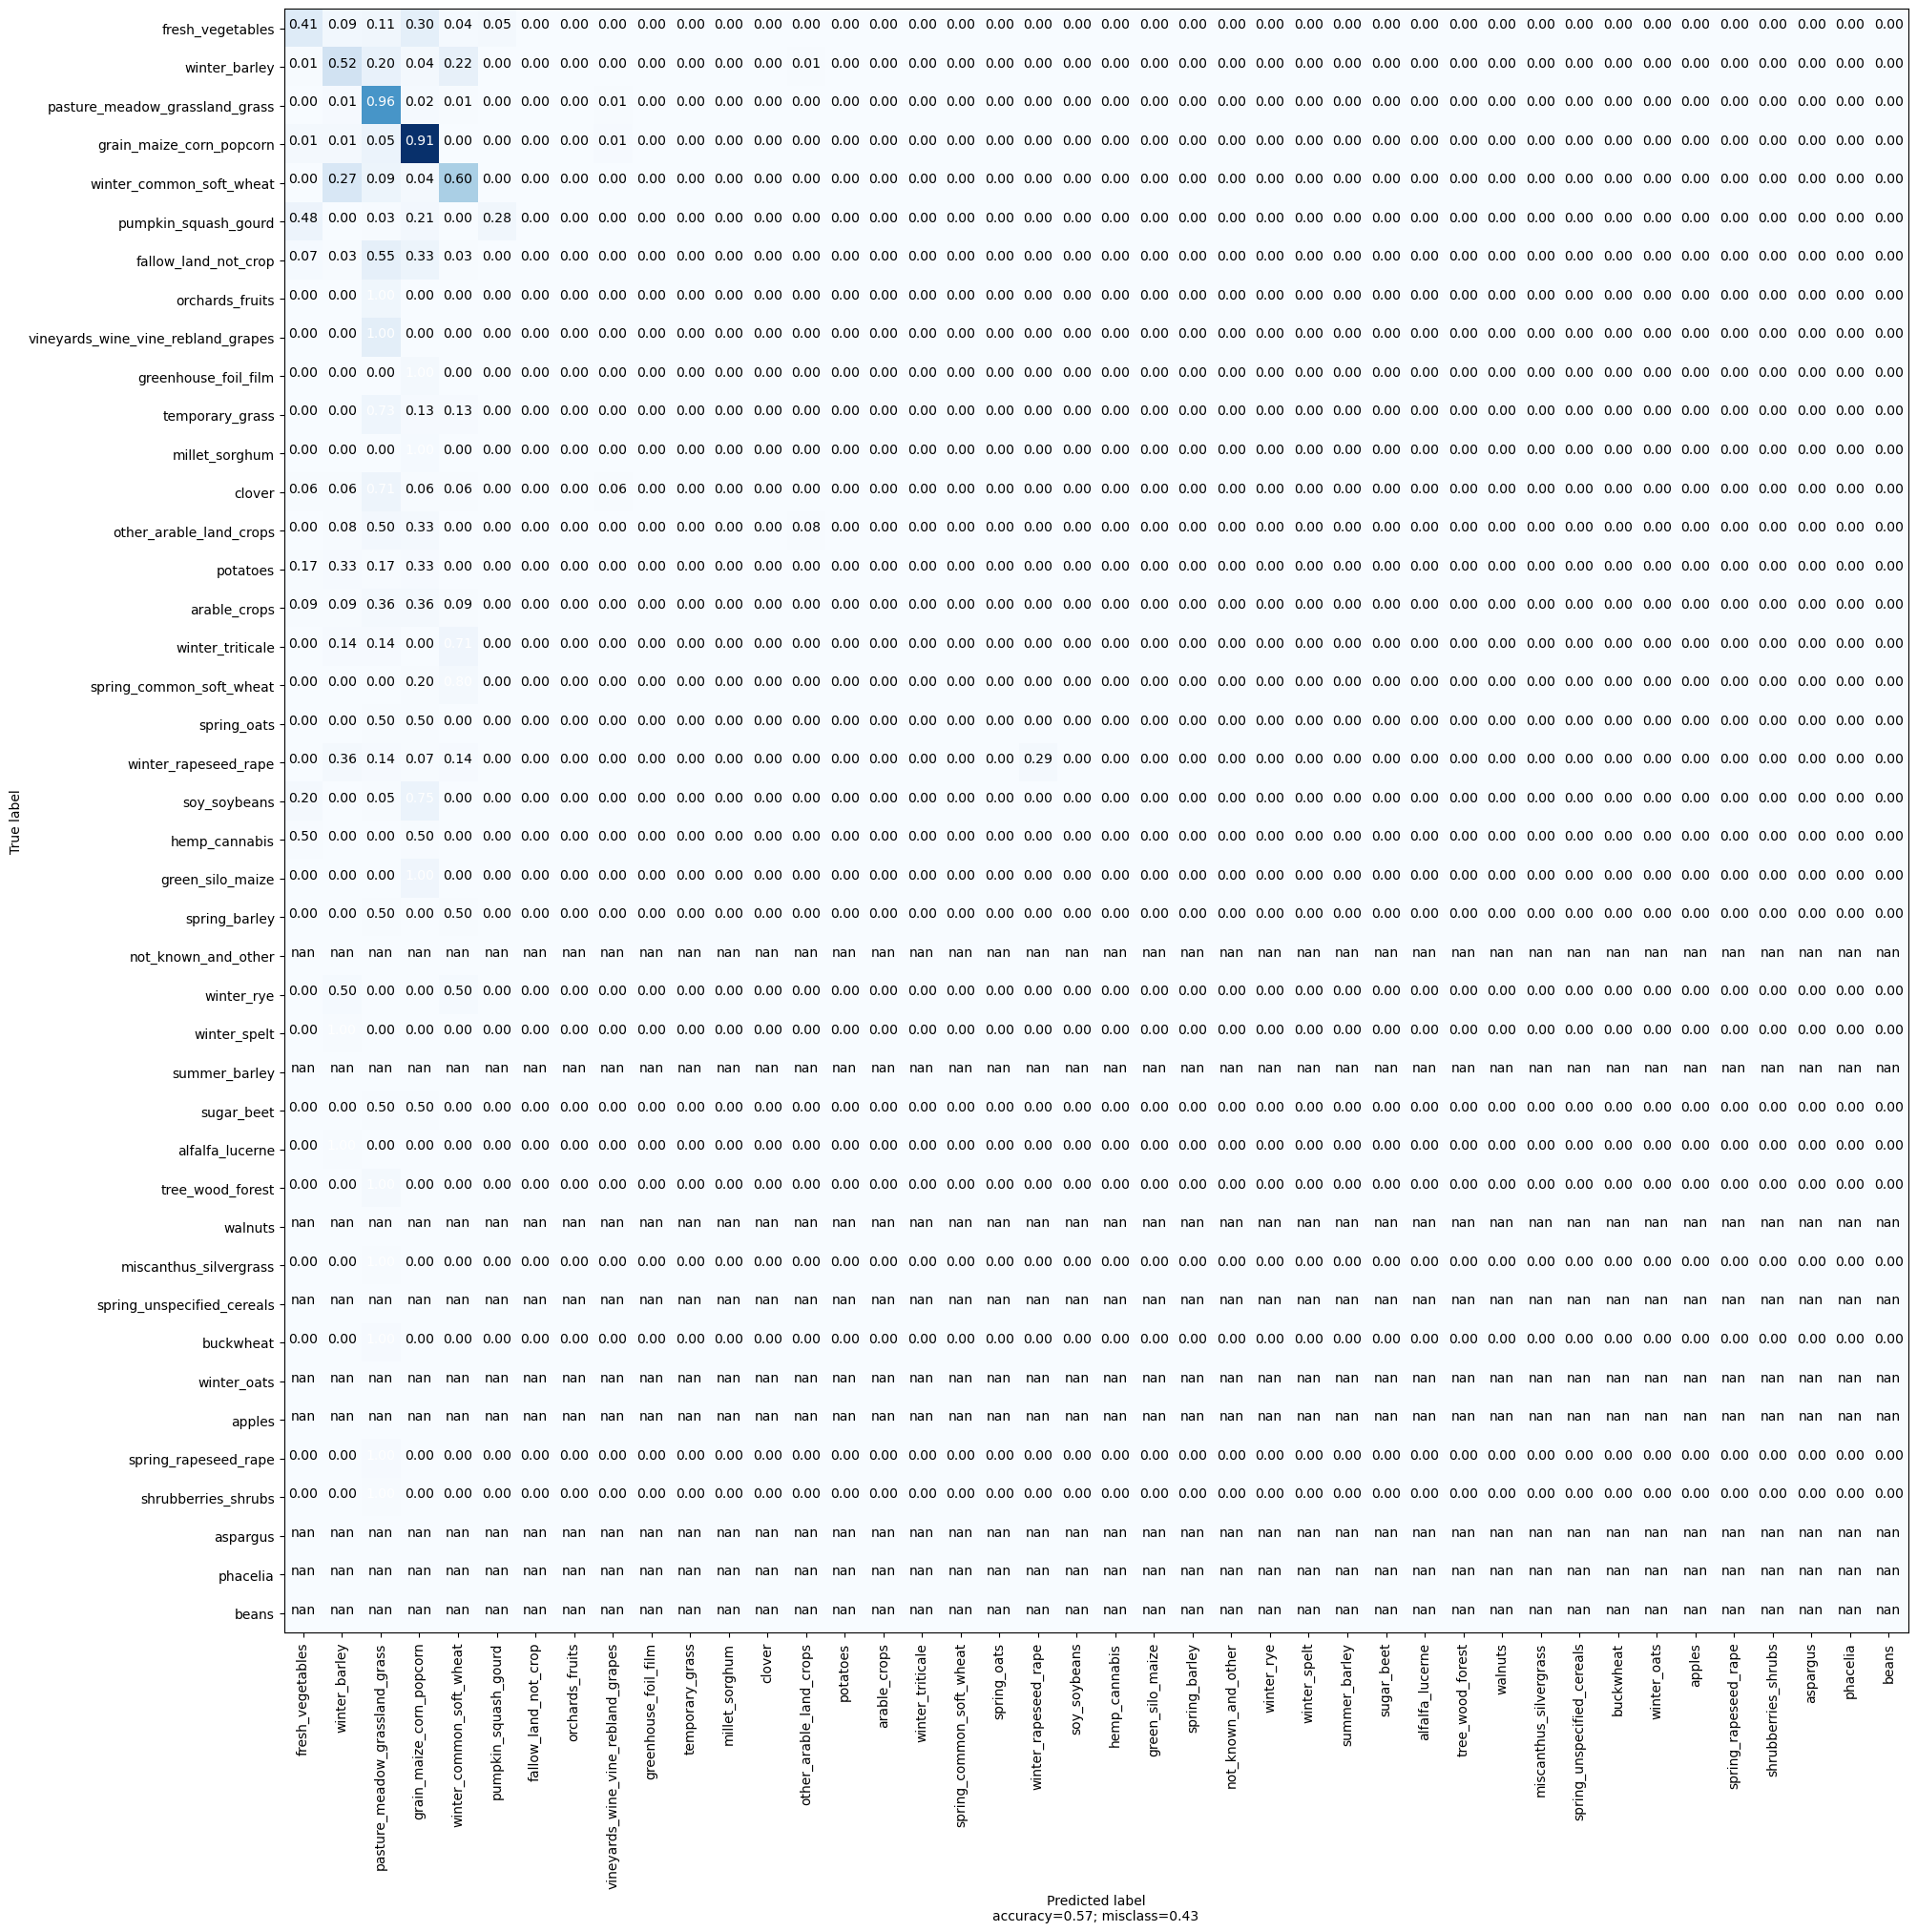

In [34]:
plot_confusion_matrix(cm, target_names=[crop_id_to_name_mapping[x] for x in crop_id_to_label_mapping.keys()])